In [1]:
# Load essential libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Load the cleaned dataset
df = pd.read_csv("data/statcast_2023.csv")

# Basic sanity checks
print(" Data loaded successfully!")
print(f"Number of rows: {len(df)}")
print(f"Number of columns: {len(df.columns)}")

# Show the first few rows
print("\n Preview of the dataset:")
print(df.head())

# List all column names
print("\n Column names:")
print(df.columns.tolist())

# Check for missing values in all columns
print("\n Missing values per column:")
print(df.isna().sum().sort_values(ascending=False))


 Data loaded successfully!
Number of rows: 720684
Number of columns: 118

 Preview of the dataset:
  pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         CH  2023-10-01           89.0          -2.80           5.59   
1         FF  2023-10-01           96.9          -2.40           5.90   
2         CH  2023-10-01           90.0          -2.93           5.56   
3         ST  2023-10-01           82.2          -3.09           5.55   
4         CH  2023-10-01           89.2          -2.87           5.58   

       player_name  batter  pitcher     events      description  ...  \
0  Robertson, Nick  677008   687798  field_out    hit_into_play  ...   
1  Robertson, Nick  677008   687798        NaN             foul  ...   
2  Robertson, Nick  677008   687798        NaN             ball  ...   
3  Robertson, Nick  677008   687798        NaN             ball  ...   
4  Robertson, Nick  677008   687798        NaN  swinging_strike  ...   

   batter_days_until_next_gam

In [2]:
# Distribution of pitch types
print("\nPitch type value counts:")
print(df['pitch_type'].value_counts())

print("\nNumber of unique pitch types:", df['pitch_type'].nunique())
print("Unique pitch types:", df['pitch_type'].unique())

# Summary statistics for release speed
print("\nSummary statistics for release_speed:")
print(df['release_speed'].describe())

# Summary statistics for release position (X, Z)
print("\nSummary statistics for release_pos_x:")
print(df['release_pos_x'].describe())

print("\nSummary statistics for release_pos_z:")
print(df['release_pos_z'].describe())



Pitch type value counts:
pitch_type
FF    230316
SL    115424
SI    111147
CH     77862
FC     56800
CU     47483
ST     42001
FS     16056
KC     14862
SV      2890
FA      1114
FO       778
EP       558
KN       192
SC        74
CS        70
PO        46
Name: count, dtype: int64

Number of unique pitch types: 17
Unique pitch types: ['CH' 'FF' 'ST' 'SI' 'FC' 'CU' 'SV' 'SL' 'FS' 'KC' nan 'KN' 'EP' 'FA' 'PO'
 'FO' 'CS' 'SC']

Summary statistics for release_speed:
count    717837.000000
mean         88.998881
std           6.109994
min          33.400000
25%          84.600000
50%          89.800000
75%          93.900000
max         104.800000
Name: release_speed, dtype: float64

Summary statistics for release_pos_x:
count    717835.000000
mean         -0.859685
std           1.826846
min          -4.850000
25%          -2.140000
50%          -1.530000
75%           0.750000
max           4.740000
Name: release_pos_x, dtype: float64

Summary statistics for release_pos_z:
count    7178

#### Pitch Type Distribution:
The dataset is heavily skewed toward fastballs (FF), which make up nearly a third of all pitches. This confirms a strong class imbalance that will need to be addressed during modeling (e.g., via stratified sampling or class weighting).

#### Release Speed: 
Most pitches fall between 85–94 mph, with a few extreme outliers (as low as 33.4 mph, likely knuckleballs or error readings). The median is ~89.8 mph.

#### Release Position:
- release_pos_x ranges from -4.85 to 4.74 feet, with a mean of -0.86 — suggesting most pitchers release the ball slightly to the left (from the catcher’s perspective).
- release_pos_z is tightly clustered around 5.8 feet, which makes sense for shoulder-height releases.

In [3]:
# Crosstab of pitch type vs batter handedness
print("\nPitch type vs batter handedness (stand):")
print(pd.crosstab(df['pitch_type'], df['stand'], normalize='columns').round(3))

# Crosstab of pitch type vs pitcher handedness
print("\nPitch type vs pitcher handedness (p_throws):")
print(pd.crosstab(df['pitch_type'], df['p_throws'], normalize='columns').round(3))


Pitch type vs batter handedness (stand):
stand           L      R
pitch_type              
CH          0.128  0.095
CS          0.000  0.000
CU          0.075  0.060
EP          0.001  0.001
FA          0.002  0.002
FC          0.085  0.075
FF          0.345  0.303
FO          0.001  0.001
FS          0.032  0.015
KC          0.024  0.018
KN          0.000  0.000
PO          0.000  0.000
SC          0.000  0.000
SI          0.122  0.179
SL          0.134  0.180
ST          0.046  0.067
SV          0.004  0.004

Pitch type vs pitcher handedness (p_throws):
p_throws        L      R
pitch_type              
CH          0.140  0.097
CS          0.000  0.000
CU          0.074  0.063
EP          0.000  0.001
FA          0.000  0.002
FC          0.071  0.082
FF          0.327  0.319
FO          0.000  0.001
FS          0.004  0.029
KC          0.015  0.023
KN          0.000  0.000
PO          0.000  0.000
SC          0.000  0.000
SI          0.164  0.152
SL          0.147  0.166
ST          

#### Batter handedness (stand):
- Right-handed batters (R) see more sliders (SL) and sinkers (SI) than left-handed batters (L).
- Left-handed batters get more changeups (CH) and cutters (FC) proportionally.
- Four-seam fastballs (FF) dominate for both sides, but slightly more for lefties.

#### Pitcher handedness (p_throws):
- Left-handed pitchers throw more changeups (CH) and sinkers (SI) proportionally than righties.
- Right-handed pitchers throw more splitters (FS) and sliders (SL).
- Fastball usage is nearly identical across both groups.

In [4]:
# Create a new column for count (e.g., "0-0", "1-2", etc.)
df['count'] = df['balls'].astype(str) + "-" + df['strikes'].astype(str)

# Top 10 most common counts
print("\nTop 10 most common counts:")
print(df['count'].value_counts().head(10))

# Crosstab of pitch type vs count (normalized by column)
print("\nPitch type distribution across common counts (normalized):")
common_counts = df['count'].value_counts().head(10).index.tolist()
count_subset = df[df['count'].isin(common_counts)]
print(pd.crosstab(count_subset['pitch_type'], count_subset['count'], normalize='columns').round(3))


Top 10 most common counts:
count
0-0    184478
0-1     93208
1-1     72613
1-0     70686
1-2     69795
2-2     59617
0-2     48924
2-1     37484
3-2     36274
2-0     24208
Name: count, dtype: int64

Pitch type distribution across common counts (normalized):
count         0-0    0-1    0-2    1-0    1-1    1-2    2-0    2-1    2-2  \
pitch_type                                                                  
CH          0.070  0.134  0.113  0.122  0.148  0.124  0.089  0.124  0.130   
CS          0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
CU          0.079  0.066  0.086  0.051  0.063  0.083  0.025  0.045  0.073   
EP          0.001  0.001  0.000  0.001  0.001  0.000  0.001  0.001  0.000   
FA          0.002  0.001  0.001  0.002  0.001  0.001  0.002  0.002  0.001   
FC          0.086  0.083  0.049  0.096  0.083  0.053  0.103  0.095  0.062   
FF          0.332  0.284  0.318  0.315  0.279  0.303  0.389  0.314  0.303   
FO          0.000  0.001  0.002  0.000  0.001  

#### 0-0 count (start of at-bat): 
Pitchers lean heavily on fastballs (FF), with sliders (SL) and sinkers (SI) also common. This is a low-risk count, so pitchers often establish with power pitches.
#### Two-strike counts (e.g. 0-2, 1-2, 2-2): 
Increased usage of off-speed pitches like sliders (SL), curveballs (CU), and splitters (FS). These are often used to induce swings and misses.
#### Three-ball counts (e.g. 3-2, 2-0): 
Fastball usage spikes — especially in 3-2 — likely due to the need to avoid walks and challenge hitters in the zone.
- This confirms that count pressure influences pitch selection, and balls/strikes will be valuable features in our model.

In [5]:
# Pitch type distribution by inning (normalized)
print("\nPitch type distribution by inning (1–9):")
inning_subset = df[df['inning'].between(1, 9)]
print(pd.crosstab(inning_subset['pitch_type'], inning_subset['inning'], normalize='columns').round(3))

# Pitch type distribution by outs (0, 1, 2)
print("\nPitch type distribution by number of outs:")
print(pd.crosstab(df['pitch_type'], df['outs_when_up'], normalize='columns').round(3))


Pitch type distribution by inning (1–9):
inning          1      2      3      4      5      6      7      8      9
pitch_type                                                               
CH          0.100  0.109  0.128  0.131  0.129  0.112  0.100  0.087  0.077
CS          0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
CU          0.068  0.079  0.083  0.083  0.080  0.068  0.049  0.044  0.039
EP          0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.003  0.005
FA          0.000  0.000  0.000  0.000  0.000  0.000  0.001  0.005  0.010
FC          0.079  0.081  0.083  0.083  0.082  0.081  0.074  0.070  0.079
FF          0.379  0.348  0.319  0.308  0.307  0.304  0.304  0.305  0.313
FO          0.001  0.001  0.001  0.001  0.002  0.001  0.001  0.000  0.000
FS          0.020  0.019  0.021  0.021  0.019  0.020  0.023  0.028  0.031
KC          0.021  0.022  0.025  0.024  0.022  0.020  0.016  0.014  0.023
KN          0.000  0.000  0.000  0.001  0.001  0.000  0.000  0.000  0.

#### By Inning:
- Fastballs (FF) are most common early in the game (especially inning 1), then gradually decline.
- Sliders (SL) and sinkers (SI) increase in usage in later innings, possibly reflecting fatigue or strategic shifts.
- Off-speed pitches like changeups (CH) and curveballs (CU) peak around innings 3–5, then taper off.
#### By Outs:
Pitch distribution is relatively stable across outs, but:
- Fastballs are slightly more common with 0 outs.
- Sliders and curveballs increase slightly with 2 outs — possibly to induce strikeouts or weak contact.

 All histograms saved to plots\numeric_feature_histograms.pdf


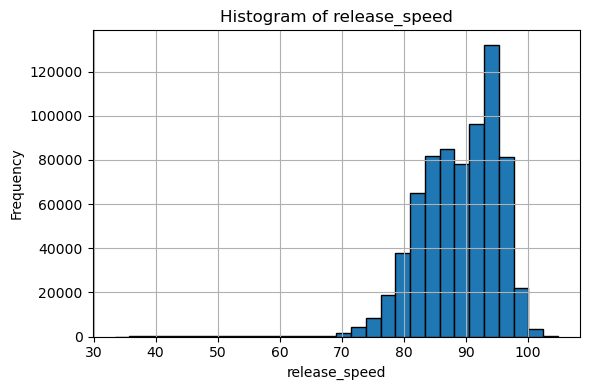

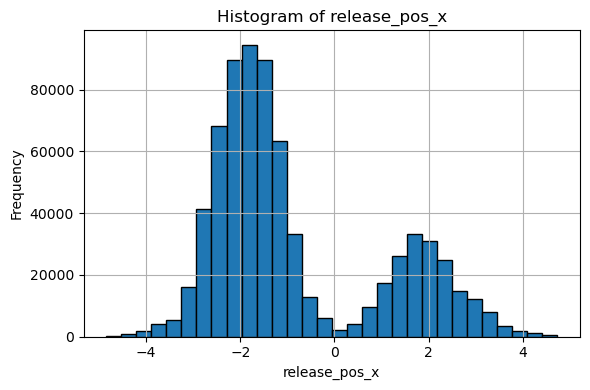

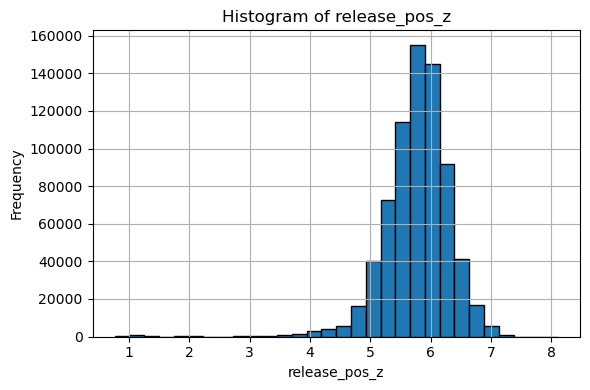

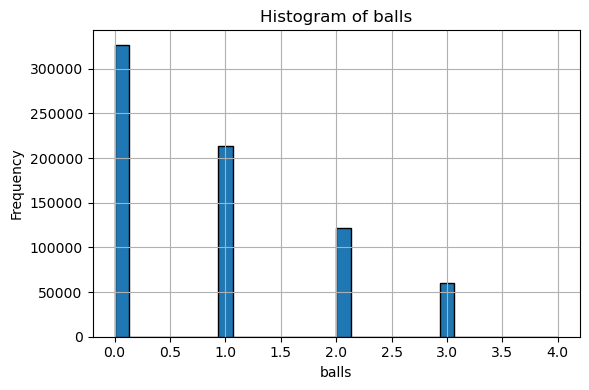

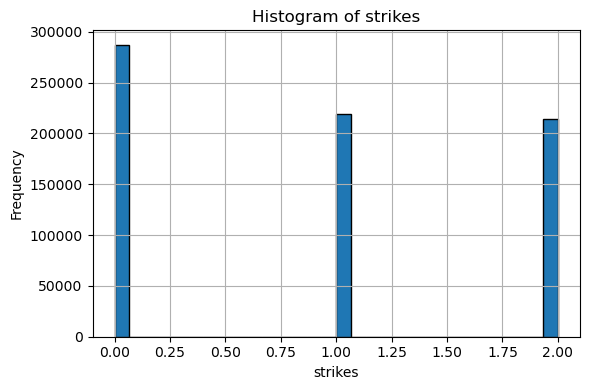

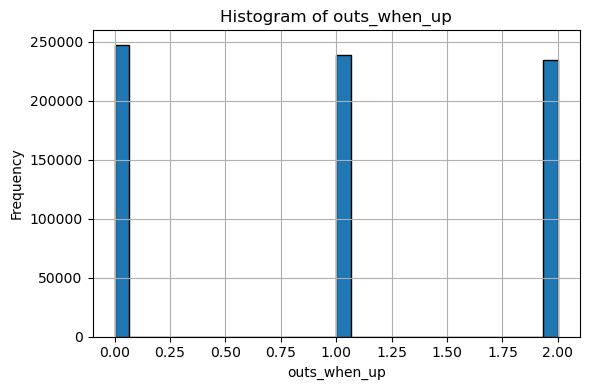

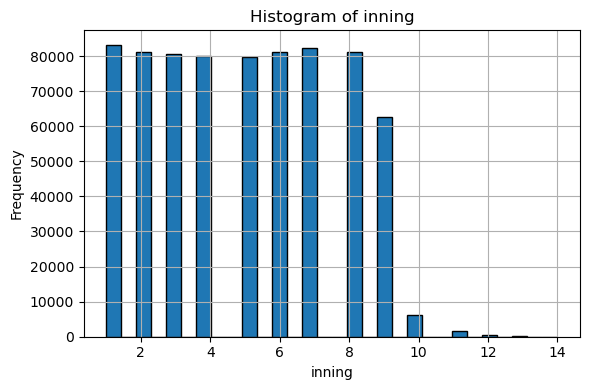

In [8]:
# Features to plot
plot_dir = "plots"
numeric_features = ['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes', 'outs_when_up', 'inning']

# Save all histograms to a single PDF
pdf_path = os.path.join(plot_dir, "numeric_feature_histograms.pdf")
with PdfPages(pdf_path) as pdf:
    for col in numeric_features:
        plt.figure(figsize=(6, 4))
        df[col].hist(bins=30, edgecolor='black')
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.tight_layout()
        pdf.savefig()
        plt.close()

print(f" All histograms saved to {pdf_path}")

# Plot histograms
for col in numeric_features:
    plt.figure(figsize=(6, 4))
    df[col].hist(bins=30, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#### release_speed: 
Strong central peak around 90 mph, with a long tail toward slower pitches (e.g., knuckleballs, changeups). This confirms it's a highly informative feature with clear separation potential.
#### release_pos_x:
Bimodal distribution, likely reflecting left- vs. right-handed pitchers. This supports its use as a handedness proxy or mechanical signature.
#### release_pos_z: 
Tight clustering around 5.8 feet, consistent with shoulder-height release. Minimal outliers.
#### balls and strikes: 
Discrete distributions with expected peaks at common counts like 0–0, 1–1, and 2–2. These features are categorical in nature and should be treated accordingly in modeling.
#### outs_when_up: 
Fairly even distribution across 0, 1, and 2 outs — no major imbalance.
#### inning: 
Slightly decreasing frequency from innings 1 to 9, likely due to pitcher substitutions and game dynamics.

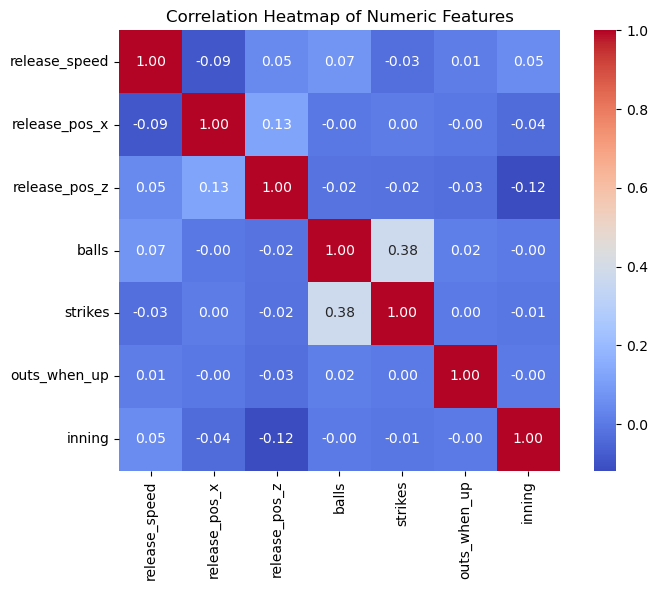

Correlation heatmap saved to plots\correlation_heatmap.pdf


In [9]:
import seaborn as sns

# Compute correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot and save correlation heatmap
pdf_path = os.path.join(plot_dir, "correlation_heatmap.pdf")
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()

with PdfPages(pdf_path) as pdf:
    pdf.savefig()
plt.show()
plt.close()

print(f"Correlation heatmap saved to {pdf_path}")


- release_speed has very weak correlations with other features (all close to 0). This means velocity is largely independent and will provide unique predictive power.
- release_pos_x and release_pos_z show a modest positive correlation (0.13). This makes sense: pitchers with certain arm slots tend to have consistent horizontal and vertical release points.
- balls and strikes are moderately correlated (0.38). That’s expected since they both progress together as the count develops.
- inning has weak negative correlation with release_pos_z (-0.12). This could reflect fatigue or mechanical adjustments later in games.
- outs_when_up is essentially uncorrelated with everything else, meaning it’s an independent contextual feature.

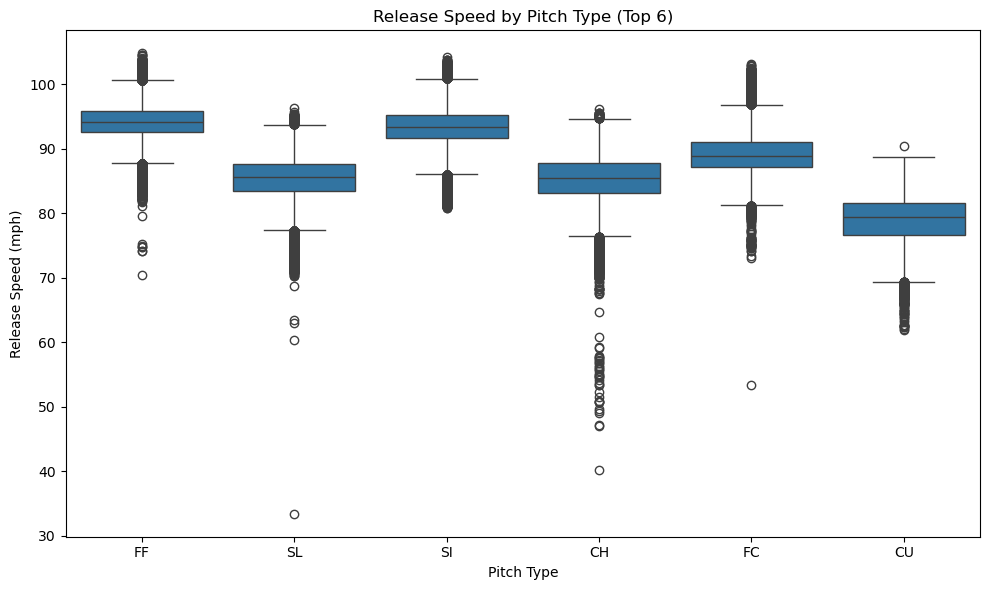

Boxplot saved to plots\release_speed_by_pitch_type.pdf


In [10]:
# Top 6 most common pitch types
top_pitches = df['pitch_type'].value_counts().head(6).index.tolist()
df_top = df[df['pitch_type'].isin(top_pitches)]

# Save and show boxplot
pdf_path = os.path.join(plot_dir, "release_speed_by_pitch_type.pdf")
plt.figure(figsize=(10, 6))
sns.boxplot(x='pitch_type', y='release_speed', data=df_top, order=top_pitches)
plt.title("Release Speed by Pitch Type (Top 6)")
plt.xlabel("Pitch Type")
plt.ylabel("Release Speed (mph)")
plt.tight_layout()

with PdfPages(pdf_path) as pdf:
    pdf.savefig()
plt.show()
plt.close()

print(f"Boxplot saved to {pdf_path}")

- Fastballs (FF) sit clearly at the top end of the velocity spectrum, clustering around 95–100 mph.
- Sliders (SL) and curveballs (CU) are slower, typically in the 75–85 mph range, showing strong separation from fastballs.
- Sinkers (SI) overlap with fastballs but trend slightly lower, often in the 90–94 mph range.
- Changeups (CH) are distinctly slower, usually 80–85 mph, which makes them effective for deception.
- Cutters (FC) fall between fastballs and sliders, showing intermediate velocity.

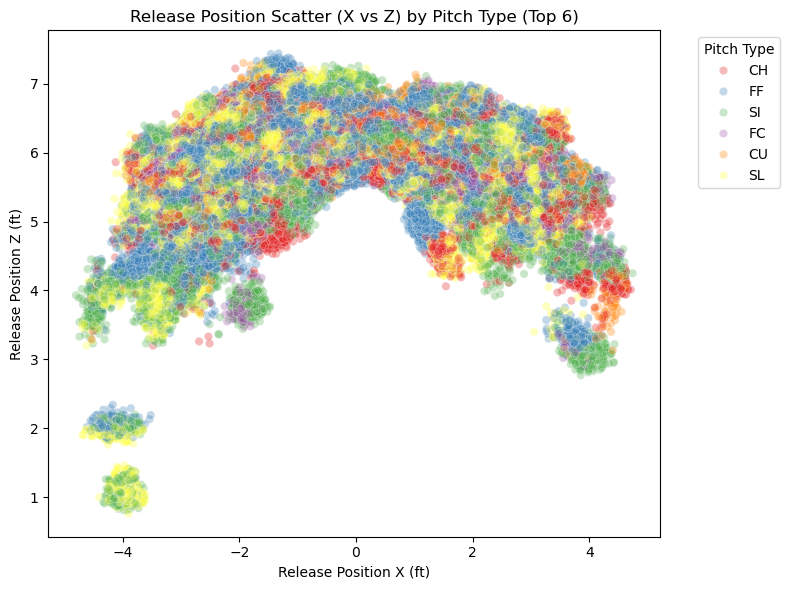

Scatterplot saved to plots\release_position_scatter.pdf


In [11]:
# Scatterplot of release position (X vs Z) for top 6 pitch types
pdf_path = os.path.join(plot_dir, "release_position_scatter.pdf")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='release_pos_x',
    y='release_pos_z',
    hue='pitch_type',
    data=df_top,
    alpha=0.3,
    palette='Set1'
)
plt.title("Release Position Scatter (X vs Z) by Pitch Type (Top 6)")
plt.xlabel("Release Position X (ft)")
plt.ylabel("Release Position Z (ft)")
plt.legend(title="Pitch Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

with PdfPages(pdf_path) as pdf:
    pdf.savefig()
plt.show()
plt.close()

print(f"Scatterplot saved to {pdf_path}")